# Import Libraries

In [1]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


Method:

Use the entire training set (train + val) to train the model using the selected hyperparameters and use the weights from the final trained model to run inference using the test set.

# Load features and labels from train and val pickle

In [2]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_audio_features_not_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [3]:
audio_df

{'train': {'mfcc': array([[[0.2926833 , 0.5472208 , 0.51762646, ..., 0.42902297,
           0.5246572 , 0.39747417],
          [0.38219857, 0.63193434, 0.4692648 , ..., 0.4789598 ,
           0.5143834 , 0.35231233],
          [0.4352324 , 0.62795496, 0.4937711 , ..., 0.53823024,
           0.5205363 , 0.36665156],
          ...,
          [0.6295364 , 0.3740691 , 0.4684327 , ..., 0.74904454,
           0.6659465 , 0.13212648],
          [0.6729512 , 0.37194872, 0.47004578, ..., 0.63276273,
           0.6894711 , 0.25973636],
          [0.6984098 , 0.35604227, 0.50428545, ..., 0.49908003,
           0.694181  , 0.40737295]],
  
         [[0.571982  , 0.52721703, 0.35377806, ..., 0.31411108,
           0.45345846, 0.5325761 ],
          [0.57278824, 0.51283437, 0.33133256, ..., 0.44663262,
           0.59104645, 0.5540432 ],
          [0.5442881 , 0.50030595, 0.39622635, ..., 0.4177069 ,
           0.63780564, 0.5152073 ],
          ...,
          [0.65820706, 0.30996823, 0.5541669 , ..

In [4]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [5]:
non_audio_df

{'train': {'type': array(['blank', 'blank', 'blank', ..., 'blank', 'blank', 'blank'],
        dtype='<U5'),
  'continent': array(['AFRICA', 'AFRICA', 'AFRICA', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5., 5., 5., ..., 5., 5., 5.]),
  'label': array([0, 0, 0, ..., 2, 2, 2])},
 'val': {'type': array(['song', 'call', 'call', ..., 'blank', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([3.5, 5. , 4. , ..., 5. , 3. , 3. ]),
  'label': array([0, 0, 1, ..., 2, 1, 2])}}

## confirm the audio features and non_audio features labels line-up

In [6]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [7]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Combine Train and Val into one large train df

In [8]:
audio_df['train'].keys()

dict_keys(['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'label'])

In [9]:
def combined(train_dict, val_dict):
  comb_dict = {}
  for key in train_dict.keys():
    train = train_dict[key]
    val = val_dict[key]
    comb_dict[key] = np.concatenate((train, val), axis=0)

  return comb_dict

In [10]:
audio_train = combined(audio_df['train'], audio_df['val'])
non_audio_train = combined(non_audio_df['train'], non_audio_df['val'])

In [11]:
assert len(audio_train['label']) == len(audio_df['train']['label']) + len(audio_df['val']['label'])
assert len(non_audio_train['label']) == len(non_audio_df['train']['label']) + len(non_audio_df['val']['label'])

# Load the test df

In [12]:
with open('/content/drive/MyDrive/Projects/test_features_pkl/test_8_sec_audio_features_not_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [13]:
with open('/content/drive/MyDrive/Projects/test_features_pkl/test_8_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

# Shuffle the data

In [14]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [15]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_train, non_audio_train)

In [16]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(7193, 251, 20)

array([[[0.82256675, 0.780536  , 0.3538675 , ..., 0.454634  ,
         0.5367174 , 0.48056254],
        [0.8163663 , 0.76919276, 0.33277017, ..., 0.6076405 ,
         0.5143846 , 0.4775143 ],
        [0.77403307, 0.7275808 , 0.39288855, ..., 0.66717744,
         0.5121502 , 0.51241845],
        ...,
        [0.7423126 , 0.76040435, 0.45125037, ..., 0.54145455,
         0.55885136, 0.3659794 ],
        [0.75616884, 0.76989216, 0.4523509 , ..., 0.45200887,
         0.49554992, 0.41634732],
        [0.77360106, 0.7422466 , 0.49990502, ..., 0.410721  ,
         0.5446986 , 0.5194754 ]],

       [[0.6737862 , 0.52718544, 0.17777058, ..., 0.42629215,
         0.49914682, 0.44093177],
        [0.6575966 , 0.49386352, 0.17618012, ..., 0.5933219 ,
         0.59147775, 0.5195479 ],
        [0.617802  , 0.45482987, 0.19183064, ..., 0.70122194,
         0.64814764, 0.5177016 ],
        ...,
        [0.6111175 , 0.46429074, 0.23277399, ..., 0.5299947 ,
         0.52850074, 0.56011987],
        [0.6

'chroma'

(7193, 251, 12)

array([[[8.1953824e-01, 4.9348089e-01, 4.9608135e-01, ...,
         6.8677419e-01, 9.9999994e-01, 8.5961396e-01],
        [9.9932313e-01, 7.8773367e-01, 6.0326266e-01, ...,
         7.3049277e-01, 9.2758781e-01, 9.5374101e-01],
        [6.3358194e-01, 7.9996145e-01, 5.2504027e-01, ...,
         6.5820551e-01, 4.6494329e-01, 4.7005501e-01],
        ...,
        [9.0256995e-01, 9.3711054e-01, 6.7518330e-01, ...,
         5.8820802e-01, 5.6355298e-01, 6.5769315e-01],
        [6.0974520e-01, 6.1021888e-01, 6.5983349e-01, ...,
         5.4730785e-01, 5.6907725e-01, 5.5456239e-01],
        [7.6106995e-01, 6.5793359e-01, 8.7484026e-01, ...,
         9.0783674e-01, 8.6510187e-01, 8.0260992e-01]],

       [[5.4166633e-01, 6.1206293e-01, 5.6189364e-01, ...,
         9.7415805e-01, 9.0861416e-01, 8.7744665e-01],
        [6.7205948e-01, 9.9269724e-01, 8.4706396e-01, ...,
         9.2278731e-01, 7.2385198e-01, 7.8104854e-01],
        [5.8245331e-01, 7.0180517e-01, 5.6151497e-01, ...,
         5.545

'rms'

(7193, 251, 1)

array([[[0.03816495],
        [0.04074664],
        [0.04332534],
        ...,
        [0.03732314],
        [0.03406311],
        [0.02938359]],

       [[0.01090987],
        [0.01316246],
        [0.01371227],
        ...,
        [0.01507317],
        [0.01311256],
        [0.01046653]],

       [[0.0018729 ],
        [0.00235655],
        [0.00246788],
        ...,
        [0.00543294],
        [0.00428266],
        [0.00352778]],

       [[0.06206883],
        [0.06850006],
        [0.06339214],
        ...,
        [0.01484701],
        [0.0053878 ],
        [0.0019155 ]],

       [[0.03883288],
        [0.04375768],
        [0.04653008],
        ...,
        [0.06071905],
        [0.05674422],
        [0.04781973]]], dtype=float32)

'spectral_centroid'

(7193, 251, 1)

array([[[0.21942196],
        [0.21981935],
        [0.23313908],
        ...,
        [0.21382548],
        [0.22255169],
        [0.24770688]],

       [[0.37151991],
        [0.39008375],
        [0.38713462],
        ...,
        [0.38707043],
        [0.37592117],
        [0.37057234]],

       [[0.39368195],
        [0.46227935],
        [0.45038658],
        ...,
        [0.60088728],
        [0.60408115],
        [0.61414885]],

       [[0.80244269],
        [0.7637771 ],
        [0.74377786],
        ...,
        [0.54514057],
        [0.36265053],
        [0.34476329]],

       [[0.22125117],
        [0.21844579],
        [0.22582883],
        ...,
        [0.23330867],
        [0.24196875],
        [0.24333296]]])

'melspectrogram'

(7193, 251, 20)

array([[[0.7418051 , 0.7744847 , 0.75971293, ..., 0.49975052,
         0.4461201 , 0.43173778],
        [0.7302211 , 0.78007513, 0.7716148 , ..., 0.5035498 ,
         0.4365737 , 0.4122321 ],
        [0.72111344, 0.7849688 , 0.74751896, ..., 0.5183414 ,
         0.4331073 , 0.42070293],
        ...,
        [0.7919754 , 0.77348554, 0.7505661 , ..., 0.4765942 ,
         0.42255378, 0.3789667 ],
        [0.782252  , 0.7779156 , 0.7484033 , ..., 0.49730211,
         0.44338724, 0.3950598 ],
        [0.7744694 , 0.7657554 , 0.72170866, ..., 0.54567605,
         0.47908372, 0.4256545 ]],

       [[0.39082503, 0.40287143, 0.45565063, ..., 0.4623919 ,
         0.46511686, 0.48509765],
        [0.33295092, 0.36645743, 0.43997818, ..., 0.47395074,
         0.47922927, 0.4804173 ],
        [0.23990482, 0.34802252, 0.43535492, ..., 0.4806027 ,
         0.48646864, 0.48972714],
        ...,
        [0.27255553, 0.34100628, 0.44442597, ..., 0.4967198 ,
         0.4753625 , 0.4669342 ],
        [0.3

'label'

(7193,)

array([1, 0, 1, 2, 1])

In [17]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(7193,)

array(['call', 'song', 'call', 'song', 'call'], dtype='<U5')

'continent'

(7193,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(7193,)

array([4. , 3. , 4. , 4.5, 4. ])

'label'

(7193,)

array([1, 0, 1, 2, 1])

In [18]:
audio_df['test'], non_audio_df['test'] = shuffle_data(audio_df['test'], non_audio_df['test'])

In [19]:
for key in audio_df['test'].keys():
  display(key)
  display(audio_df['test'][key].shape)
  display(audio_df['test'][key][:5])

'mfcc'

(3402, 251, 20)

array([[[0.02372861, 0.52633107, 0.4999631 , ..., 0.4318599 ,
         0.4817172 , 0.46540797],
        [0.02322352, 0.5308934 , 0.44511673, ..., 0.5657563 ,
         0.5722662 , 0.55301297],
        [0.09463251, 0.5795628 , 0.3971825 , ..., 0.62030363,
         0.67082405, 0.5267171 ],
        ...,
        [0.5476467 , 0.5954528 , 0.308389  , ..., 0.4973706 ,
         0.6903301 , 0.37454483],
        [0.56417805, 0.64765674, 0.3122852 , ..., 0.49999526,
         0.66454923, 0.38030055],
        [0.57284164, 0.6564509 , 0.33403134, ..., 0.544744  ,
         0.6536446 , 0.3431434 ]],

       [[0.69387674, 0.55932266, 0.35195816, ..., 0.4145421 ,
         0.58634984, 0.4069497 ],
        [0.6897172 , 0.5424658 , 0.31625473, ..., 0.50872236,
         0.60022587, 0.4539662 ],
        [0.6554079 , 0.51965123, 0.35950714, ..., 0.60535   ,
         0.6523392 , 0.5446383 ],
        ...,
        [0.60888565, 0.5381689 , 0.47095865, ..., 0.49383155,
         0.5508694 , 0.42041627],
        [0.6

'chroma'

(3402, 251, 12)

array([[[5.7725793e-01, 8.0336076e-01, 7.4793077e-01, ...,
         8.6536968e-01, 8.7823635e-01, 6.7347956e-01],
        [6.6276872e-01, 7.3997438e-01, 6.1522532e-01, ...,
         1.0000000e+00, 8.0491573e-01, 7.0477498e-01],
        [6.7477721e-01, 3.6937875e-01, 2.3009998e-01, ...,
         3.5437557e-01, 3.9040184e-01, 6.1197251e-01],
        ...,
        [5.7031286e-01, 2.8016147e-01, 1.6932249e-01, ...,
         4.1161263e-01, 4.3492341e-01, 4.7082305e-01],
        [5.6652814e-01, 4.8415759e-01, 2.4311237e-01, ...,
         4.3520325e-01, 3.9930081e-01, 4.2393377e-01],
        [5.0037342e-01, 9.2862809e-01, 4.1769072e-01, ...,
         4.9504939e-01, 2.4935226e-01, 2.6534936e-01]],

       [[5.4190737e-01, 4.0643027e-01, 5.4226327e-01, ...,
         2.0200494e-01, 2.7162132e-01, 3.7978187e-01],
        [7.4775988e-01, 7.0429659e-01, 7.2458243e-01, ...,
         3.8455907e-01, 4.9613807e-01, 4.2802498e-01],
        [7.9842144e-01, 1.0000001e+00, 8.0896062e-01, ...,
         6.067

'rms'

(3402, 251, 1)

array([[[1.26525629e-06],
        [3.32516320e-05],
        [1.11740905e-04],
        ...,
        [8.66328739e-03],
        [8.00475013e-03],
        [6.57764729e-03]],

       [[1.02239372e-02],
        [1.09578846e-02],
        [1.14503242e-02],
        ...,
        [7.38531444e-03],
        [6.71736058e-03],
        [5.58949588e-03]],

       [[1.33273318e-01],
        [1.55141994e-01],
        [1.74398378e-01],
        ...,
        [5.73354661e-01],
        [5.72225749e-01],
        [5.27904391e-01]],

       [[1.54595496e-03],
        [1.65969820e-03],
        [1.77512749e-03],
        ...,
        [1.56627910e-03],
        [1.40128157e-03],
        [1.14183570e-03]],

       [[5.27277552e-02],
        [4.79580835e-02],
        [5.89436442e-02],
        ...,
        [2.44786520e-03],
        [2.16732291e-03],
        [1.73932803e-03]]], dtype=float32)

'spectral_centroid'

(3402, 251, 1)

array([[[0.57056015],
        [0.54958505],
        [0.38744434],
        ...,
        [0.27765736],
        [0.2732988 ],
        [0.26570376]],

       [[0.43966076],
        [0.43429431],
        [0.44648337],
        ...,
        [0.48255673],
        [0.48686877],
        [0.48048014]],

       [[0.25309323],
        [0.28198534],
        [0.46335449],
        ...,
        [0.62635613],
        [0.65816264],
        [0.62634588]],

       [[0.2858503 ],
        [0.27801647],
        [0.29098412],
        ...,
        [0.28417311],
        [0.28469134],
        [0.27894196]],

       [[0.49647435],
        [0.49419357],
        [0.52872129],
        ...,
        [0.54501673],
        [0.55744637],
        [0.55777913]]])

'melspectrogram'

(3402, 251, 20)

array([[[0.045587  , 0.05035943, 0.0327906 , ..., 0.01005042,
         0.01418847, 0.03735697],
        [0.04378635, 0.03763521, 0.0406701 , ..., 0.01073432,
         0.00845039, 0.01630944],
        [0.05646557, 0.06224561, 0.15691149, ..., 0.01003402,
         0.01742822, 0.01861495],
        ...,
        [0.38590568, 0.45902553, 0.60028446, ..., 0.3814149 ,
         0.37234586, 0.36668476],
        [0.38201863, 0.46081135, 0.61173075, ..., 0.36478436,
         0.38514778, 0.3781619 ],
        [0.40164864, 0.4561551 , 0.5712671 , ..., 0.35869   ,
         0.39455906, 0.38335815]],

       [[0.5238309 , 0.55543303, 0.50682294, ..., 0.4949983 ,
         0.50678384, 0.5226669 ],
        [0.4943205 , 0.5093875 , 0.51239073, ..., 0.5050404 ,
         0.50128543, 0.49921796],
        [0.4604267 , 0.49904436, 0.5058086 , ..., 0.5151863 ,
         0.48809657, 0.5140717 ],
        ...,
        [0.5096111 , 0.49653897, 0.5082896 , ..., 0.48239887,
         0.49368328, 0.4865553 ],
        [0.5

'label'

(3402,)

array([1, 2, 2, 1, 0])

In [20]:
for key in non_audio_df['test'].keys():
  display(key)
  display(non_audio_df['test'][key].shape)
  display(non_audio_df['test'][key][:5])

'type'

(3402,)

array(['call', 'song', 'call', 'call', 'song'], dtype='<U5')

'continent'

(3402,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(3402,)

array([5. , 2. , 3. , 4. , 4.5])

'label'

(3402,)

array([1, 2, 2, 1, 0])

# Create sample weights based on rating

In [21]:
training_sample_weights = non_audio_df['train']['rating']

training_sample_weights

array([4. , 3. , 4. , ..., 4. , 4.5, 3. ])

In [22]:
test_sample_weights = non_audio_df['test']['rating']

test_sample_weights

array([5. , 2. , 3. , ..., 5. , 5. , 4.5])

In [23]:
training_sample_weights = np.where(training_sample_weights > 3.0, 0.6, 0.4)

training_sample_weights

array([0.6, 0.4, 0.6, ..., 0.6, 0.6, 0.4])

In [24]:
test_sample_weights = np.where(test_sample_weights > 3.0, 0.6, 0.4)

test_sample_weights

array([0.6, 0.4, 0.4, ..., 0.6, 0.6, 0.6])

# GRU Models

In [25]:
classes = ['barswa', 'comsan', 'eaywag1']

## Create GRU model function

In [26]:
def build_model(audio_features,
                learning_rate=0.002,
                gru=256,
                hidden=[256,128,48],
                dropout=0.3):

  tf.keras.backend.clear_session()

  # set audio features input layer
  audio_features = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # add sequential model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GRU(gru, input_shape=(audio_features.shape[1],audio_features.shape[2])))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout))

  for size in hidden:
    model.add(tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dropout(dropout))

  model.add(tf.keras.layers.Dense(units=3,activation='softmax'))

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [27]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'], color='purple', label='train_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualze the accuracy
  axes[1].plot(model_history.history['accuracy'], color='purple', label='train_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()

  plt.show()

## With mfcc & rms

### create features

In [28]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms']), axis=-1)

training_audio_features

array([[[0.82256675, 0.780536  , 0.3538675 , ..., 0.5367174 ,
         0.48056254, 0.03816495],
        [0.8163663 , 0.76919276, 0.33277017, ..., 0.5143846 ,
         0.4775143 , 0.04074664],
        [0.77403307, 0.7275808 , 0.39288855, ..., 0.5121502 ,
         0.51241845, 0.04332534],
        ...,
        [0.7423126 , 0.76040435, 0.45125037, ..., 0.55885136,
         0.3659794 , 0.03732314],
        [0.75616884, 0.76989216, 0.4523509 , ..., 0.49554992,
         0.41634732, 0.03406311],
        [0.77360106, 0.7422466 , 0.49990502, ..., 0.5446986 ,
         0.5194754 , 0.02938359]],

       [[0.6737862 , 0.52718544, 0.17777058, ..., 0.49914682,
         0.44093177, 0.01090987],
        [0.6575966 , 0.49386352, 0.17618012, ..., 0.59147775,
         0.5195479 , 0.01316246],
        [0.617802  , 0.45482987, 0.19183064, ..., 0.64814764,
         0.5177016 , 0.01371227],
        ...,
        [0.6111175 , 0.46429074, 0.23277399, ..., 0.52850074,
         0.56011987, 0.01507317],
        [0.6

In [29]:
training_audio_features.shape

(7193, 251, 21)

In [30]:
test_audio_features = np.concatenate((audio_df['test']['mfcc'], audio_df['test']['rms']), axis=-1)

test_audio_features

array([[[2.37286091e-02, 5.26331067e-01, 4.99963105e-01, ...,
         4.81717199e-01, 4.65407968e-01, 1.26525629e-06],
        [2.32235193e-02, 5.30893385e-01, 4.45116729e-01, ...,
         5.72266221e-01, 5.53012967e-01, 3.32516320e-05],
        [9.46325064e-02, 5.79562783e-01, 3.97182494e-01, ...,
         6.70824051e-01, 5.26717126e-01, 1.11740905e-04],
        ...,
        [5.47646701e-01, 5.95452785e-01, 3.08389008e-01, ...,
         6.90330088e-01, 3.74544829e-01, 8.66328739e-03],
        [5.64178050e-01, 6.47656739e-01, 3.12285215e-01, ...,
         6.64549232e-01, 3.80300552e-01, 8.00475013e-03],
        [5.72841644e-01, 6.56450927e-01, 3.34031343e-01, ...,
         6.53644621e-01, 3.43143404e-01, 6.57764729e-03]],

       [[6.93876743e-01, 5.59322655e-01, 3.51958156e-01, ...,
         5.86349845e-01, 4.06949699e-01, 1.02239372e-02],
        [6.89717174e-01, 5.42465806e-01, 3.16254735e-01, ...,
         6.00225866e-01, 4.53966200e-01, 1.09578846e-02],
        [6.55407906e-01, 

In [31]:
test_audio_features.shape

(3402, 251, 21)

### fit the model with training data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               214272    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

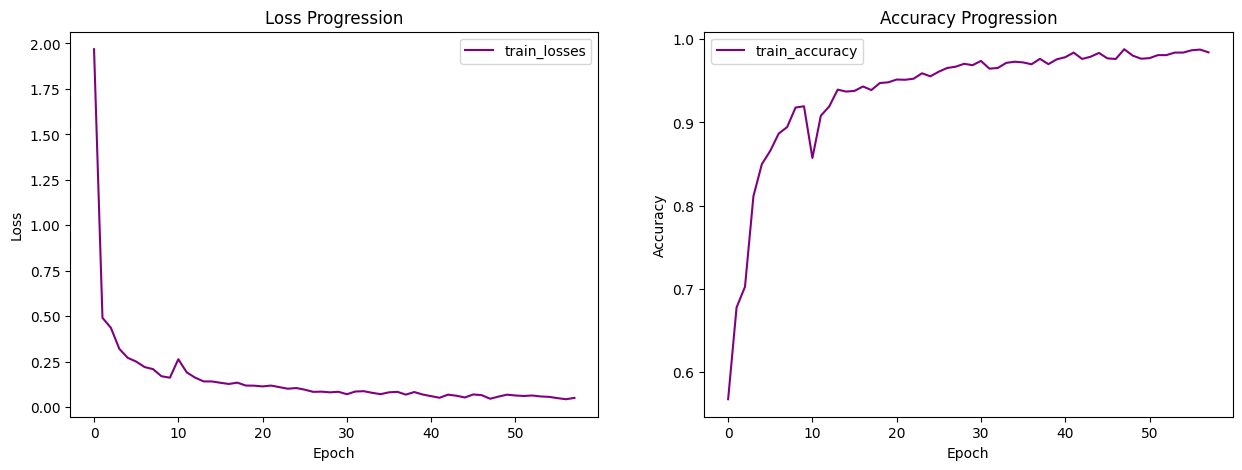

In [32]:
model = build_model(training_audio_features,
                    learning_rate=0.002,
                    gru=256,
                    hidden=[256,128,48],
                    dropout=0.3)

history = model.fit(
   x=training_audio_features,
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=58,
   batch_size=64,
   verbose=1)

visualize(history)

In [33]:
train_yhat = model.predict(training_audio_features)

train_yhat_result = np.argmax(train_yhat, axis=-1)

model.evaluate(training_audio_features,
               audio_df['train']['label'])[-1]

225/225 [==============================] - 2s 8ms/step - loss: 0.0656 - accuracy: 0.9872 - weighted_accuracy: 0.9872


0.9872097969055176

In [34]:
test_yhat = model.predict(test_audio_features)

test_yhat_result = np.argmax(test_yhat, axis=-1)

model.evaluate(test_audio_features,
               audio_df['test']['label'])[-1]

107/107 [==============================] - 1s 7ms/step - loss: 0.3034 - accuracy: 0.9347 - weighted_accuracy: 0.9347


0.9347442388534546

### evaluate the results

In [35]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      0.98      0.99      2635
      comsan       0.96      1.00      0.98      2196
     eaywag1       1.00      0.98      0.99      2362

    accuracy                           0.99      7193
   macro avg       0.99      0.99      0.99      7193
weighted avg       0.99      0.99      0.99      7193



In [36]:
print('Test classification Report \n')
print(classification_report(audio_df['test']['label'], test_yhat_result, target_names=classes))

Test classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.95      0.95      1409
      comsan       0.90      0.94      0.92       924
     eaywag1       0.96      0.90      0.93      1069

    accuracy                           0.93      3402
   macro avg       0.93      0.93      0.93      3402
weighted avg       0.94      0.93      0.93      3402



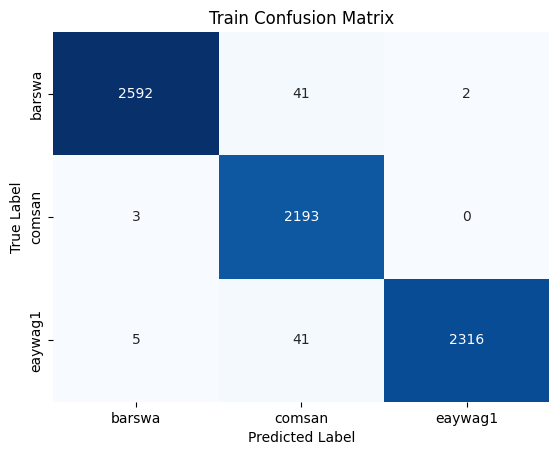

In [37]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

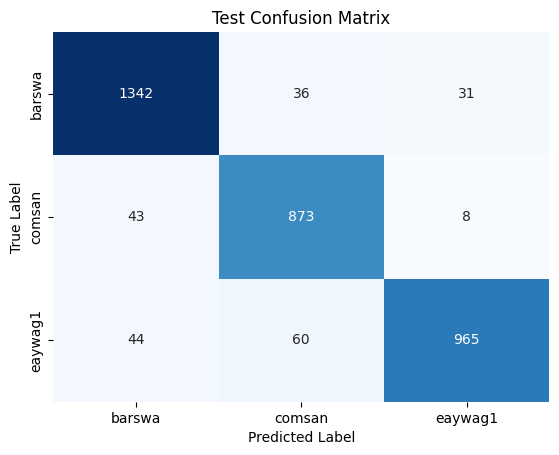

In [38]:
test_cm = tf.math.confusion_matrix(audio_df['test']['label'], test_yhat_result)

ax = sns.heatmap(test_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Test Confusion Matrix')
plt.show()